# Computer Vision : Assignment 3

### Mayank Musaddi (20171115)
#### Instructions

Download test folder from the following link:
https://drive.google.com/file/d/197b6DOaOIb8SwbD_wMxTlNC9iqa7WTb8/view?usp=sharing if not present already

Make sure to have a folder named `test` with 2 folders `bboxes` and `images` in it
Run the code in jupyter notebook with the file being present outside the test folder


In [1]:
# All the imports

import os 
import sys
import numpy as np 
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from PIL import Image
from sklearn import mixture
from math import sqrt
import igraph as ig

In [2]:
# Helper function

def show_images(images,cols=1,titles=None,bboxes=None):
    n = len(images)
    fig = plt.figure()
    
    for i,image in enumerate(images):
        ax = fig.add_subplot(cols, np.ceil(n/float(cols)),i+1)
        ca = plt.gca()
        
        if bboxes is not None:
            bbox = bboxes[i]
            ca.add_patch(Rectangle((bbox[0],bbox[1]),bbox[2]-bbox[0],bbox[3]-bbox[1],linewidth=2.5, edgecolor='red', facecolor='none'))
        
        if titles is not None:
            ax.set_title(titles[i])
            
        cv2img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        plt.imshow(cv2img)
        
            
    fig.set_size_inches(np.array(fig.get_size_inches())*n)
    plt.show()

In [3]:
# folder locations

imageFolder = './test/images/'
boxFolder = './test/bboxes/'

In [4]:
# Load all images and bbox

images = []
bboxes = []
filenames = os.listdir(imageFolder)
for filename in filenames:
    img = cv2.imread(os.path.join(imageFolder,filename))
    images.append(img)
    
    bboxFile = filename.split('.')[0]+'.txt'
    with open(os.path.join(boxFolder,bboxFile)) as f:
        cds = [int(x) for x in f.read().split()]
    bboxes.append(cds)

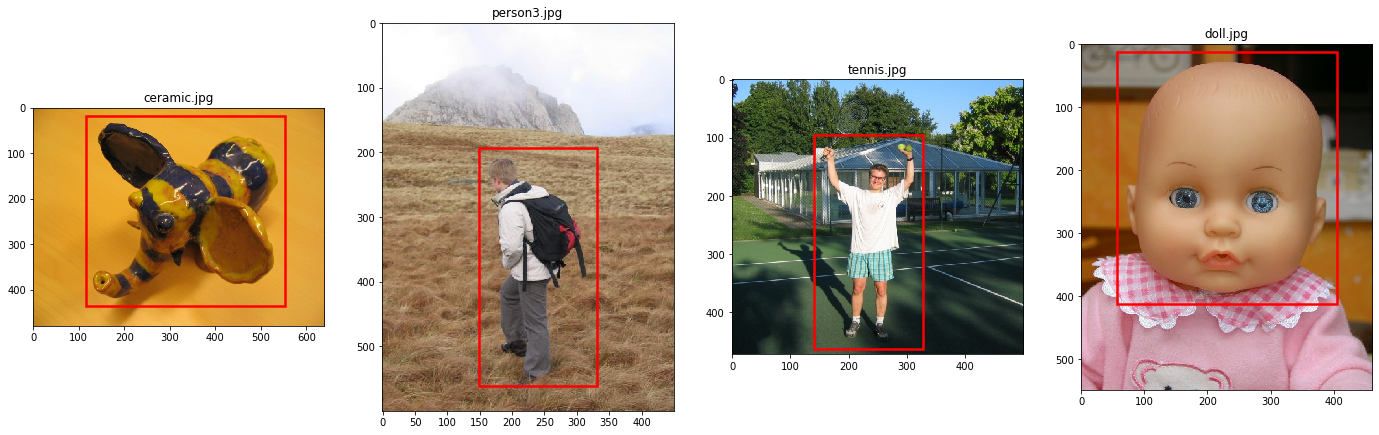

In [5]:
show_images(images[:4],titles=filenames,bboxes=bboxes)

## GrabCut Implementation

We implement Grab Cut algorithm as mentioned in this paper https://cvg.ethz.ch/teaching/cvl/2012/grabcut-siggraph04.pdf.

The idea is that we assign energies to the pixel based on gaussian mixture modeling of the foreground and background and then do graph cut on it. We run some experiments on its hyperparameters to understand its effects.

In [6]:
# Global Variables

Tb = 0
Tf = 1
Tu_b = 2
Tu_f = 3

In [7]:
class GrabCut:
    def __init__(self, img, rect=None, iters=1, gmm_components=5,gamma = 50,verbose=False,gmm=True):
        
        self.verbose = verbose
        self.img_copy = img.copy()
        self.img = np.asarray(img, dtype=np.float64)
        self.height, self.width, _ = img.shape
        self.n_pixels = self.height*self.width
        
        self.mask = np.zeros(img.shape[:2], dtype=np.uint8)  # mask initialized to Tb
        if rect is not None:
            self.mask[rect[1]:rect[1]+rect[3],rect[0]:rect[0]+rect[2]] = Tu_f
        
        self.gmm_components = gmm_components
        self.gamma,self.beta = gamma,0
        
        self.comp_idxs = np.empty((self.height, self.width), dtype=np.uint32)
        self.gc_source = self.n_pixels
        self.gc_sink = self.n_pixels+1
        
        self.classify_pixels()
        self.bgd_gmm = mixture.GaussianMixture(n_components=5).fit(self.img[self.bgd_indexes])
        self.fgd_gmm = mixture.GaussianMixture(n_components=5).fit(self.img[self.fgd_indexes])
        
        self.output_images = None
        self.gmm = gmm
        self.run(iters)
        
    def calc_grad(self):
        left    = np.square(self.img[:,1:]-self.img[:,:-1])
        upleft  = np.square(self.img[1:,1:]-self.img[:-1,:-1])
        up      = np.square(self.img[1:,:]-self.img[:-1,:])
        upright = np.square(self.img[1:,:-1]-self.img[:-1,1:])
        return left,upleft,up,upright
    
    def calc_beta(self,left,upleft,up,upright):
        sum_grads = np.sum(left)+np.sum(upleft)+np.sum(up)+np.sum(upright)
        norm_factor = 4*self.height*self.width-3*self.height-3*self.width+2
        beta = 1.0/(2*sum_grads/norm_factor)
        return beta

    def calc_smoothness(self):
        left,upleft,up,upright = self.calc_grad()
        self.beta = self.calc_beta(left,upleft,up,upright)
        
        self.left_V = self.gamma * np.exp(-self.beta*np.sum(left,axis=2))
        self.upleft_V = self.gamma/np.sqrt(2) * np.exp(-self.beta*np.sum(upleft,axis=2))
        self.up_V = self.gamma * np.exp(-self.beta*np.sum(up,axis=2))
        self.upright_V = self.gamma/np.sqrt(2) * np.exp(-self.beta*np.sum(upright,axis=2))

    def classify_pixels(self):
        self.bgd_indexes = np.where(np.logical_or(self.mask==Tb, self.mask==Tu_b))
        self.fgd_indexes = np.where(np.logical_or(self.mask==Tf, self.mask==Tu_f))

    def learn_GMM(self):
        self.comp_idxs[self.bgd_indexes] = self.bgd_gmm.predict(self.img[self.bgd_indexes])
        self.comp_idxs[self.fgd_indexes] = self.fgd_gmm.predict(self.img[self.fgd_indexes])
        self.bgd_gmm.fit(self.img[self.bgd_indexes],self.comp_idxs[self.bgd_indexes])
        self.fgd_gmm.fit(self.img[self.fgd_indexes],self.comp_idxs[self.fgd_indexes])
        
    def build_edges(self,bgd_indexes,fgd_indexes,pr_indexes):
        edges = []
        
        # t-links
        edges.extend(list(zip([self.gc_source] * pr_indexes[0].size, pr_indexes[0])))
        edges.extend(list(zip([self.gc_sink] * pr_indexes[0].size, pr_indexes[0])))
        edges.extend(list(zip([self.gc_source] * bgd_indexes[0].size, bgd_indexes[0])))
        edges.extend(list(zip([self.gc_sink] * bgd_indexes[0].size, bgd_indexes[0])))
        edges.extend(list(zip([self.gc_source] * fgd_indexes[0].size, fgd_indexes[0])))
        edges.extend(list(zip([self.gc_sink] * fgd_indexes[0].size, fgd_indexes[0])))
        
        # n-links
        img_indexes = np.arange(self.n_pixels,dtype=np.uint32).reshape(self.height,self.width)
        mask1 = img_indexes[:, 1:].reshape(-1)
        mask2 = img_indexes[:, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        
        mask1 = img_indexes[1:, 1:].reshape(-1)
        mask2 = img_indexes[:-1, :-1].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        
        mask1 = img_indexes[1:, :].reshape(-1)
        mask2 = img_indexes[:-1, :].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        
        mask1 = img_indexes[1:, :-1].reshape(-1)
        mask2 = img_indexes[:-1, 1:].reshape(-1)
        edges.extend(list(zip(mask1, mask2)))
        
        self.gc_graph = ig.Graph(self.n_pixels+2)
        self.gc_graph.add_edges(edges)
    
    def build_capacity(self,bgd_indexes,fgd_indexes,pr_indexes):
        
        self.gc_graph_capacity = []
        
        # t-links
        _D = -self.bgd_gmm.score_samples(self.img.reshape(-1, 3)[pr_indexes])
        self.gc_graph_capacity.extend(_D.tolist())
        _D = -self.fgd_gmm.score_samples(self.img.reshape(-1, 3)[pr_indexes])
        self.gc_graph_capacity.extend(_D.tolist())
        self.gc_graph_capacity.extend([0] * bgd_indexes[0].size)
        self.gc_graph_capacity.extend([9 * self.gamma] * bgd_indexes[0].size)
        self.gc_graph_capacity.extend([9 * self.gamma] * fgd_indexes[0].size)
        self.gc_graph_capacity.extend([0] * fgd_indexes[0].size)

        # n-links
        self.gc_graph_capacity.extend(self.left_V.reshape(-1).tolist())
        self.gc_graph_capacity.extend(self.upleft_V.reshape(-1).tolist())
        self.gc_graph_capacity.extend(self.up_V.reshape(-1).tolist())
        self.gc_graph_capacity.extend(self.upright_V.reshape(-1).tolist())
        
    def construct_gc_graph(self):
        bgd_indexes = np.where(self.mask.reshape(-1)==Tb)
        fgd_indexes = np.where(self.mask.reshape(-1)==Tf)
        pr_indexes = np.where(np.logical_or(self.mask.reshape(-1)==Tu_b, self.mask.reshape(-1)==Tu_f))
        self.build_edges(bgd_indexes,fgd_indexes,pr_indexes)
        self.build_capacity(bgd_indexes,fgd_indexes,pr_indexes)

    def estimate_segmentation(self):
        mincut = self.gc_graph.st_mincut(self.gc_source, self.gc_sink, self.gc_graph_capacity)
        if self.verbose:
            print('Foreground Pixels :',len(mincut.partition[0]))
            print('Background Pixels :',len(mincut.partition[1]))
        pr_indexes = np.where(np.logical_or(self.mask==Tu_b, self.mask==Tu_f))
        img_indexes = np.arange(self.n_pixels,dtype=np.uint32).reshape(self.height, self.width)
        self.mask[pr_indexes] = np.where(np.isin(img_indexes[pr_indexes], mincut.partition[0]),Tu_f, Tu_b)
        self.classify_pixels()
        
    def calc_data_term(self):
        U = 0
        for ci in range(self.gmm_components):
            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(self.mask == Tb, self.mask == Tu_b)))
            U += np.sum(-self.bgd_gmm.score_samples(self.img[idx]))
            idx = np.where(np.logical_and(self.comp_idxs == ci, np.logical_or(self.mask == Tf, self.mask == Tu_f)))
            U += np.sum(-self.fgd_gmm.score_samples(self.img[idx]))
        return U
    
    def calc_smoothness_term(self):
        mask = self.mask.copy()
        mask[np.where(mask == Tu_b)] = Tb
        mask[np.where(mask == Tu_f)] = Tf

        V = 0
        V += np.sum(self.left_V * (mask[:, 1:] == mask[:, :-1]))
        V += np.sum(self.upleft_V * (mask[1:, 1:] == mask[:-1, :-1]))
        V += np.sum(self.up_V * (mask[1:, :] == mask[:-1, :]))
        V += np.sum(self.upright_V * (mask[1:, :-1] == mask[:-1, 1:]))
        return V

    def run(self, iters):
        
        self.calc_smoothness()
        if self.verbose:
            print("----------Initial Statistics----------")
            print("Beta Value :",self.beta)
            print("Background Pixel Count :",len(self.bgd_indexes[0]))
            print("Uncertain Pixel Count :",len(self.fgd_indexes[0]))
            print("--------------------------------------")
            print()
        
        self.output_images = []
        for i in range(iters):
            if self.verbose:
                print("-------For iteration no "+str(i+1)+" --------")
            
            if self.gmm:
                self.learn_GMM()
            self.construct_gc_graph()
            self.estimate_segmentation()
            
            if self.verbose and self.gmm:
                U = self.calc_data_term()
                V = self.calc_smoothness_term()
                print('Data Term : ',U)
                print('Smoothness Term : ',V)
                print('Total Energy : ',U+V)
                print('----------------------------------')
                print()
            
            fmask = np.where((self.mask==Tf)+(self.mask==Tu_f),255, 0).astype('uint8')
            output = cv2.bitwise_and(self.img_copy,self.img_copy,mask=fmask)
            self.output_images.append(output)

### Executable and Results

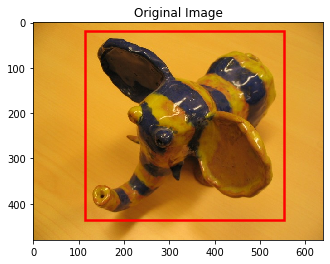

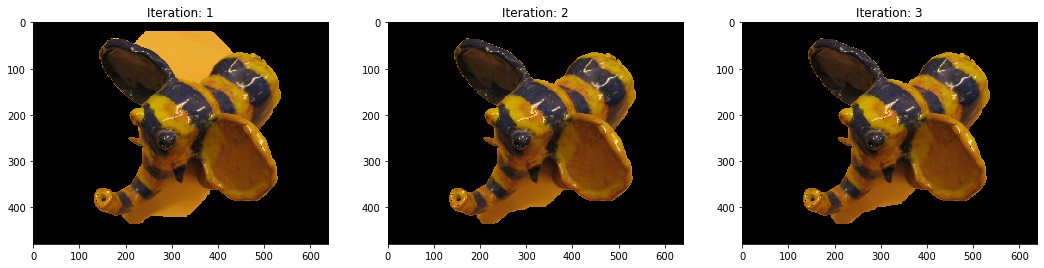

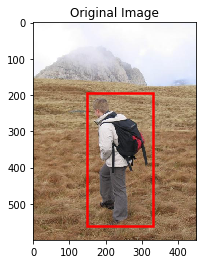

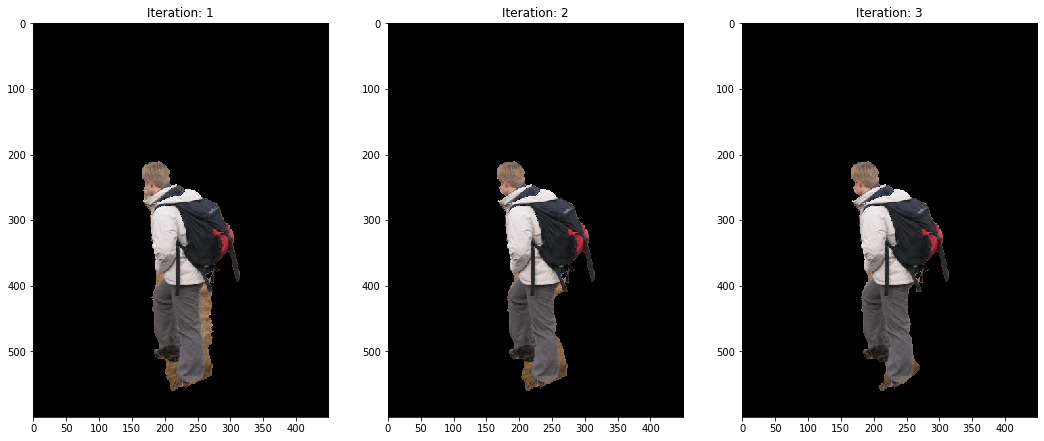

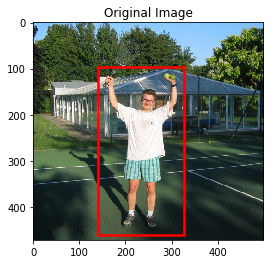

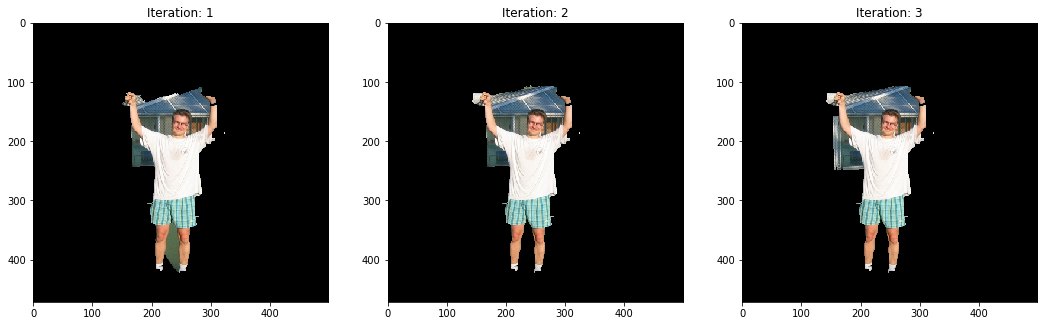

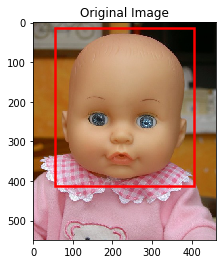

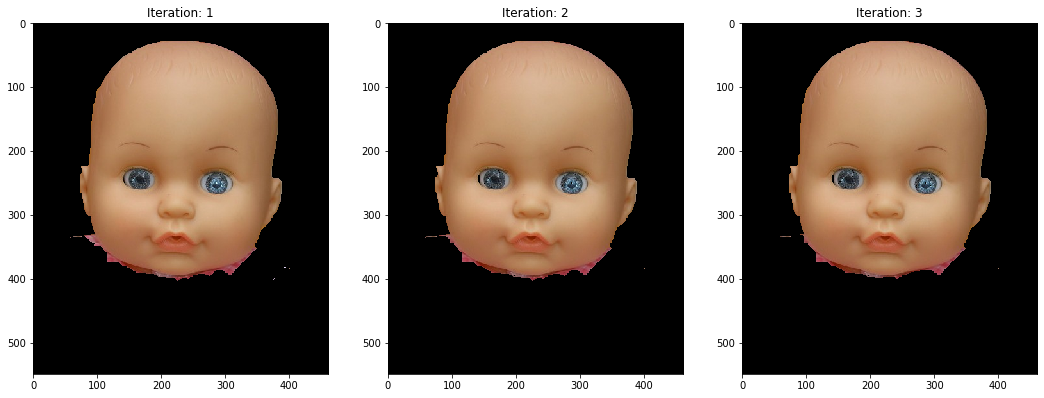

In [8]:
outputs = []
for i,image in enumerate(images[0:4]):
    x1,y1,x2,y2 = bboxes[i]
    rect = (x1,y1,x2-x1,y2-y1)
    show_images([image],bboxes=[bboxes[i]],titles=['Original Image'])
    gc = GrabCut(image, rect,iters=3)
    show_images(gc.output_images,titles=['Iteration: 1','Iteration: 2','Iteration: 3'])

## GUI for GrabCut

In [9]:
class GrabCut_GUI:
    def __init__(self,filename):
        
        self.img = cv2.imread(filename)
        self.img2 = self.img.copy()
        self.output = np.zeros(self.img.shape, np.uint8)
        self.rect = (0,0,1,1)
        self.begin = False
        self.end = False
        self.ix=0
        self.iy=0
        
        self.run()
        
    def onmouse(self,event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            self.begin = True
            self.end = False
            self.ix, self.iy = x, y
    
        elif event == cv2.EVENT_MOUSEMOVE:
            if self.begin == True:
                self.img = self.img2.copy()
                cv2.rectangle(self.img, (self.ix, self.iy), (x, y), (255, 0, 0), 2)
    
        elif event == cv2.EVENT_LBUTTONUP:
            self.begin = False
            self.end = True
            cv2.rectangle(self.img, (self.ix, self.iy), (x, y), (255, 0, 0), 2)
            self.rect = (min(self.ix, x), min(self.iy, y), abs(self.ix-x), abs(self.iy-y))
            print("Rectangle Marked. Press 'n' for GrabCut Result")
            
    def run(self):
        
        # input and output windows
        cv2.namedWindow('output')
        cv2.namedWindow('input')
        cv2.setMouseCallback('input', self.onmouse)
        cv2.moveWindow('input', self.img.shape[1]+10, 90)
        
        while(1):
            gc = None
            cv2.imshow('output', self.output)
            cv2.imshow('input', self.img)
            
            k = cv2.waitKey(1)
    
            if k == ord('r'):  # reset everything
                print("Resetting")
                self.rect = (0, 0, 1, 1)
                self.begin = False
                self.end = False
                self.img = self.img2.copy()
                self.output = np.zeros(self.img.shape, np.uint8)
                
            elif k == ord('n'):  # segment the image
                print("Computing Grabcut with Rectangle :",self.rect)
                if (self.end == True):
                    gc = GrabCut(self.img2, self.rect,verbose=True,gmm=False)
                    print("Result Displayed")
                    
            elif k == ord('x'):  # exit
                break
    
            if gc is not None:
                mask2 = np.where((gc.mask == 1) + (gc.mask == 3), 255, 0).astype('uint8')
                self.output = cv2.bitwise_and(self.img2, self.img2, mask=mask2)
    
        cv2.destroyAllWindows()

#### Usage Instructions

 - Using mouse left click and drag, create a rectangle bounding the object that needs to be segmented
 - Press `n` to confirm the bounding box and wait for the segmentation result to appear
 - Press `r` to reset the bounding box
 - Press `x` to exit

In [10]:
GrabCut_GUI(imageFolder+"/"+filenames[0])

Rectangle Marked. Press 'n' for GrabCut Result
Computing Grabcut with Rectangle : (90, 25, 481, 427)
----------Initial Statistics----------
Beta Value : 0.003966581463291084
Background Pixel Count : 101813
Uncertain Pixel Count : 205387
--------------------------------------

-------For iteration no 1 --------
Foreground Pixels : 111160
Background Pixels : 196042
Result Displayed


## Parameter Experimentation

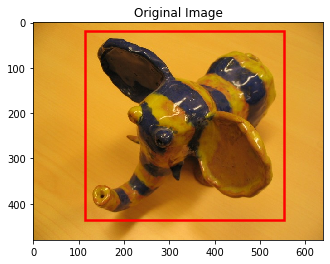

In [11]:
# Image Number
i = 0
image = images[i]
x1,y1,x2,y2 = bboxes[i]
rect = (x1,y1,x2-x1,y2-y1)
show_images([image],bboxes=[bboxes[i]],titles=['Original Image'])

### Iteration

As we can see the number of iterations increase the effectiveness of the segmentation.
With increasing iteration the image is seen to be more accurately segmented.

----------Initial Statistics----------
Beta Value : 0.003966581463291084
Background Pixel Count : 124137
Uncertain Pixel Count : 183063
--------------------------------------

-------For iteration no 1 --------
Foreground Pixels : 119036
Background Pixels : 188166
Data Term :  3281918.4421790564
Smoothness Term :  47114928.2876403
Total Energy :  50396846.72981936
----------------------------------

-------For iteration no 2 --------
Foreground Pixels : 101895
Background Pixels : 205307
Data Term :  3219151.2878455766
Smoothness Term :  47142256.04393951
Total Energy :  50361407.33178508
----------------------------------

-------For iteration no 3 --------
Foreground Pixels : 101871
Background Pixels : 205331
Data Term :  3174806.7798018176
Smoothness Term :  47142379.3740776
Total Energy :  50317186.15387942
----------------------------------



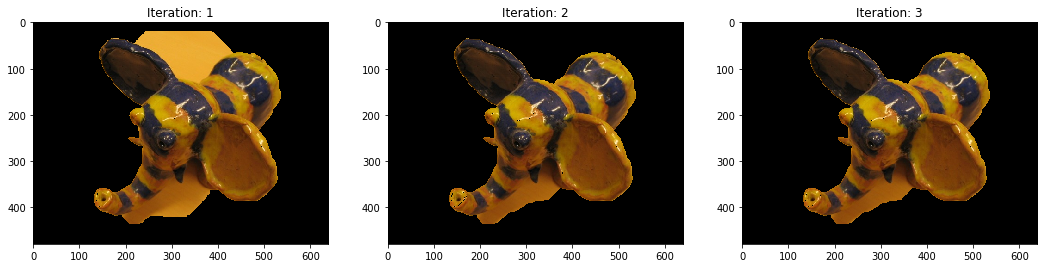

In [12]:
gc = GrabCut(image, rect,iters=3,verbose=True)
show_images(gc.output_images,titles=['Iteration: 1','Iteration: 2','Iteration: 3'])

### GMM Components

Here we notice that number of components depends on the foreground and background.
Usually k=5 is a good choice and is stable as mentioned in the paper according to the average ideal case. 
Since in the given image the number of compoenents of colors is small, the most accurate segmentation works for the case when k is smallest i.e. 1.

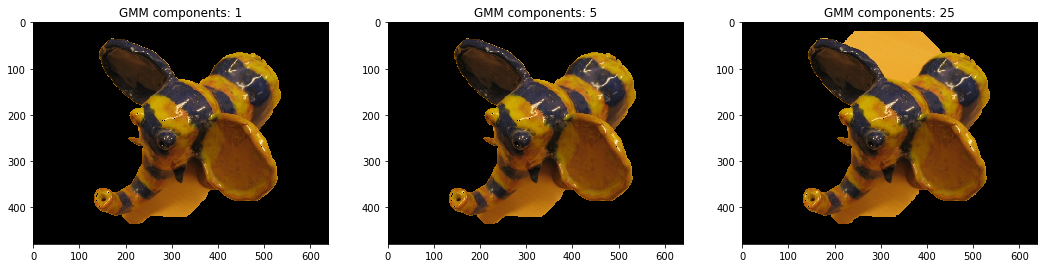

In [13]:
gc = GrabCut(image, rect, gmm_components=1)
o1 = gc.output_images

gc = GrabCut(image, rect, gmm_components=5)
o2 = gc.output_images

gc = GrabCut(image, rect, gmm_components=25)
o3 = gc.output_images

show_images(o1+o2+o3,titles=['GMM components: 1','GMM components: 5','GMM components: 25'])

### Gamma

We observe that a good gamma is able to segment in less iterations. A large gamma is prone
to errors. As mentioned in the paper as well gamma=50 works well for most cases. In case of this image the segmentation of image is better in case of gamma being 250 since it is moving in higher steps of EM and able to converge to the minima faster and accurately.

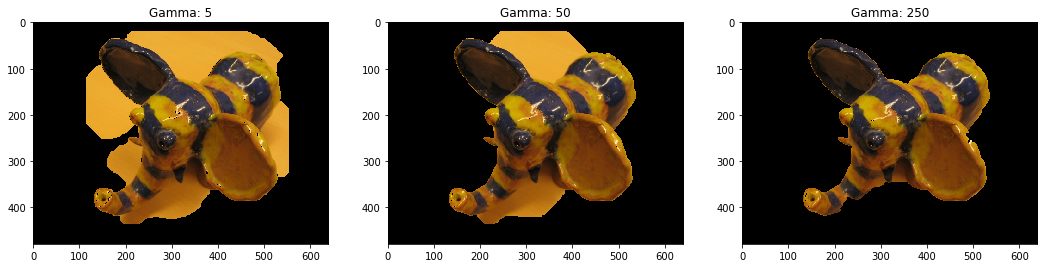

In [14]:
gc = GrabCut(image, rect, gamma=5)
o1 = gc.output_images

gc = GrabCut(image, rect, gamma=50)
o2 = gc.output_images

gc = GrabCut(image, rect, gamma=250)
o3 = gc.output_images

show_images(o1+o2+o3,titles=['Gamma: 5','Gamma: 50','Gamma: 250'])

### Color Space

We experiment with different color spaces namely RGB, LAB and YCrCb. The idea is to see where the clustering of GMM is better.
The clustering of GMM will vary from image to image depending on the color space. However it is observed that RGB works well for most of the cases, in the case for out image the result is best in case of LAB.

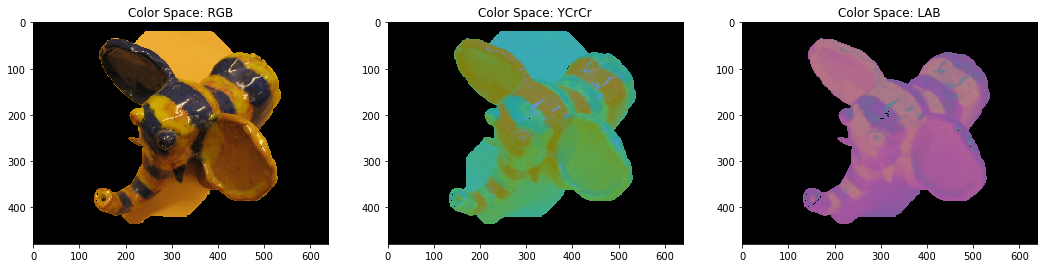

In [15]:
gc = GrabCut(image,rect)
o1 = gc.output_images

image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
gc = GrabCut(image, rect)
o2 = gc.output_images

image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
gc = GrabCut(image, rect)
o3 = gc.output_images

show_images(o1+o2+o3,titles=['Color Space: RGB','Color Space: YCrCr','Color Space: LAB'])